In [84]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [85]:
data = pd.read_csv("DaNang.csv", parse_dates=["date"], dayfirst=True, index_col=["date"])
data = data.sort_index()
start_date = '2019-03-01'
end_date = '2024-03-01'
df = data.loc[start_date:end_date]
df

,Index,pm25,pm10,o3,no2,so2,co,AQI
date,,,,,,,,
2019-03-01,1501,60,28,41,11,3,7,60
2019-03-02,1512,78,31,41,11,2,7,78
2019-03-03,1523,90,25,41,11,1,7,90
2019-03-04,1526,77,28,41,11,1,7,77
2019-03-05,1527,81,44,41,11,1,7,81
...,...,...,...,...,...,...,...,...
2024-02-26,3045,32,16,41,16,11,2,41
2024-02-27,3046,32,12,41,14,11,3,41
2024-02-28,3047,17,23,41,14,11,4,41


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1643 entries, 2019-03-01 to 2024-03-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Index   1643 non-null   int64
 1   pm25    1643 non-null   int64
 2   pm10    1643 non-null   int64
 3   o3      1643 non-null   int64
 4   no2     1643 non-null   int64
 5   so2     1643 non-null   int64
 6   co      1643 non-null   int64
 7   AQI     1643 non-null   int64
dtypes: int64(8)
memory usage: 115.5 KB


In [87]:
df_aqi = pd.DataFrame(df["AQI"])

In [88]:
timesteps = df_aqi.index.to_numpy()
aqi_arr = df_aqi["AQI"].to_numpy()

In [89]:
timesteps

array(['2019-03-01T00:00:00.000000000', '2019-03-02T00:00:00.000000000',
       '2019-03-03T00:00:00.000000000', ...,
       '2024-02-28T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [90]:
aqi_arr

array([60, 78, 90, ..., 41, 41, 41])

**Building and testing he N-BEATS block layer**

In [91]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon:    int,
               n_neurons:  int,
               n_layers:   int,
               **kwargs):


    super().__init__(**kwargs)
    self.input_size= input_size
    self.theta_size= theta_size
    self.horizon = horizon
    self.n_neurons= n_neurons
    self.n_layers= n_layers

    self.hidden=[tf.keras.layers.Dense(n_neurons, activation='relu', name=f"Fully_Connected_Layer_{i}") for i in range(1,n_layers+1) ]
    self.theta_layer=tf.keras.layers.Dense(theta_size, activation='linear',name='theta')


  def call(self,inputs):

    x= inputs

    for layer in self.hidden :
      x= layer(x)

    theta= self.theta_layer(x)

    # output the backcast and forecast
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast


**Making dummy inputs and outputs for testing our NBeatsBlock class**

In [92]:
WINDOW_SIZE=100
HORIZON=1
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=HORIZON+WINDOW_SIZE,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs


# passing dummy inputs
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")



Backcast: [  5.849916   -40.90665     -0.53772116 -14.666941    23.601177
  13.518982    -1.2651432  -26.716599     7.4041147  -23.279076
  12.149164    -5.184784    28.221344    -3.8057873    7.2727833
   1.5663601   -6.2374926   22.771187    -6.022831     5.8033085
 -23.37076     -5.161583    13.183323    -1.030765   -11.580783
  15.627844    -6.0976367    3.531927     0.6892481   43.16534
   5.581338   -12.613224   -25.688301     5.6863604    8.628998
  11.342541     0.75350523 -10.034197    19.541773     9.053771
  45.49585     -5.7468386   -5.7256823   -2.5622225  -26.957443
 -26.254677    29.220163    -1.1334016   24.239096     2.1097293
  12.340846     5.3889265  -21.559822     9.7321615  -10.5712805
 -17.69096      6.0816717   -3.2338092   -1.1752267  -17.419935
 -15.414055     5.445979    -3.6896043   10.43428    -32.00942
 -24.552006    -9.584424    -3.789414    -3.802368    12.792188
  -8.687032     9.085695   -13.139602    13.894394   -11.752786
  15.6004305   27.871538    

**Preparing data for the N-BEATS algorithm using tf.data**

In [93]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2019-03-01,60
2019-03-02,78
2019-03-03,90
2019-03-04,77
2019-03-05,81
...,...
2024-02-26,41
2024-02-27,41
2024-02-28,41


In [94]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2019-08-12,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0,78.0,60.0
2019-08-13,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0,78.0
2019-08-14,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0
2019-08-15,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,138.0,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0
2019-08-16,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,120.0,138.0,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,41,41.0,41.0,41.0,41.0,41.0,62.0,43.0,59.0,41.0,...,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0,54.0,54.0
2024-02-27,41,41.0,41.0,41.0,41.0,41.0,41.0,62.0,43.0,59.0,...,189.0,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0,54.0
2024-02-28,41,41.0,41.0,41.0,41.0,41.0,41.0,41.0,62.0,43.0,...,65.0,189.0,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0


**NBEATS(7:3)**

In [95]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [96]:
split_size = int(len(x) * 0.7)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1150, 1150, 493, 493)

In [97]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Setting up hyperparameters for N-BEATS algorithm**

In [98]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

**Getting ready for residual connections**

In [99]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


**Building, compiling and fitting the N-BEATS algorithm**

In [100]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [101]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 401ms/step - loss: 36.7182 - mae: 36.7182 - mse: 5470.2769


[36.71821594238281, 36.71821594238281, 5470.27685546875]

In [102]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [103]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 36.718216, 'rmse': 73.96132, 'mape': 50.667328}

**Make predictions into future**

In [104]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [105]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 1s 1s/step
Predicting on: 
 date
2023-11-24     98
2023-11-25    166
2023-11-26     57
2023-11-27     54
2023-11-28    106
             ... 
2024-02-26     41
2024-02-27     41
2024-02-28     41
2024-02-29     41
2024-03-01     41
Name: AQI, Length: 90, dtype: int64 -> Prediction: 67.5620346069336

1/1 [==============================] - 1s 1s/step
Predicting on: 
 [166.          57.          54.         106.         189.
  65.          54.          54.          54.          54.
  54.          54.          84.          54.          97.
 139.          54.          72.          70.          66.
  54.          54.          54.          86.         128.
  54.          54.          54.          54.          54.
  54.          54.          54.          54.          54.
 112.         181.         144.         114.          91.
  41.          41.          41.          41.          41.
  46.          52.          41.          41.          46.
  41.         

In [106]:
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)

(1150, 493)

In [107]:
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

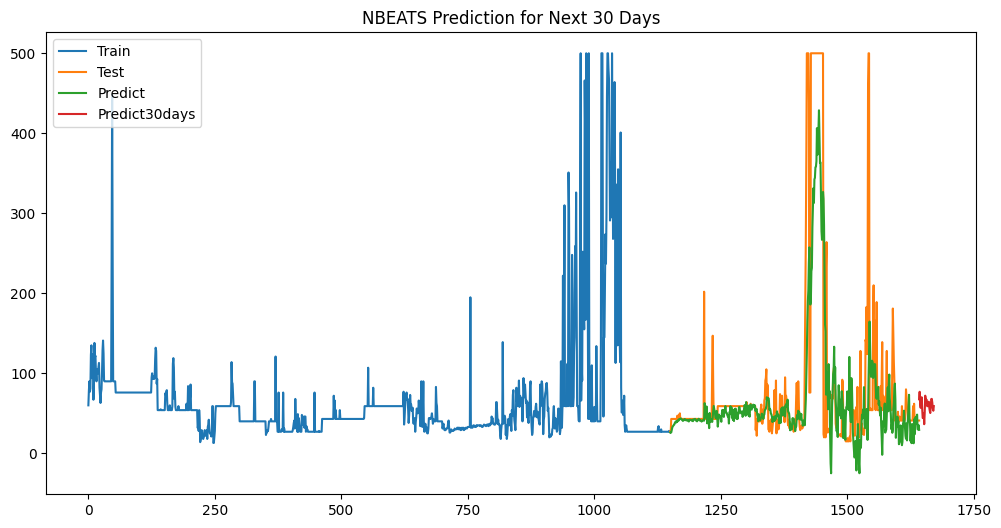

In [108]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

**NBEATS(8:2)**


In [109]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2019-03-01,60
2019-03-02,78
2019-03-03,90
2019-03-04,77
2019-03-05,81
...,...
2024-02-26,41
2024-02-27,41
2024-02-28,41


In [110]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2019-08-12,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0,78.0,60.0
2019-08-13,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0,78.0
2019-08-14,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0
2019-08-15,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,138.0,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0
2019-08-16,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,120.0,138.0,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,41,41.0,41.0,41.0,41.0,41.0,62.0,43.0,59.0,41.0,...,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0,54.0,54.0
2024-02-27,41,41.0,41.0,41.0,41.0,41.0,41.0,62.0,43.0,59.0,...,189.0,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0,54.0
2024-02-28,41,41.0,41.0,41.0,41.0,41.0,41.0,41.0,62.0,43.0,...,65.0,189.0,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0


In [111]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [112]:
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1314, 1314, 329, 329)

In [113]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [114]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [115]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [116]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [117]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 279ms/step - loss: 67.7037 - mae: 67.7037 - mse: 9084.4336


[67.70368194580078, 67.70368194580078, 9084.43359375]

In [118]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [119]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 67.70368, 'rmse': 95.312294, 'mape': 149.96002}

In [120]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [121]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 1s 1s/step
Predicting on: 
 date
2023-11-24     98
2023-11-25    166
2023-11-26     57
2023-11-27     54
2023-11-28    106
             ... 
2024-02-26     41
2024-02-27     41
2024-02-28     41
2024-02-29     41
2024-03-01     41
Name: AQI, Length: 90, dtype: int64 -> Prediction: 115.92138671875

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [166.          57.          54.         106.         189.
  65.          54.          54.          54.          54.
  54.          54.          84.          54.          97.
 139.          54.          72.          70.          66.
  54.          54.          54.          86.         128.
  54.          54.          54.          54.          54.
  54.          54.          54.          54.          54.
 112.         181.         144.         114.          91.
  41.          41.          41.          41.          41.
  46.          52.          41.          41.          46.
  41.          

In [122]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

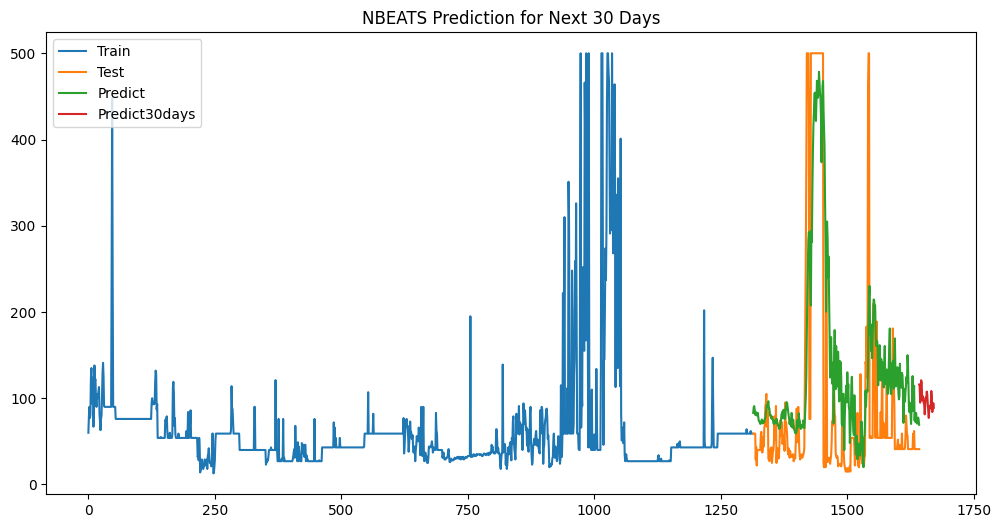

In [123]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

**NBEAT(9:1)**

In [124]:
WINDOW_SIZE=90
HORIZON=1
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2019-08-12,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0,78.0,60.0
2019-08-13,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0,78.0
2019-08-14,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0,90.0
2019-08-15,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,138.0,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0,77.0
2019-08-16,76,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,...,120.0,138.0,89.0,67.0,124.0,107.0,94.0,135.0,123.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,41,41.0,41.0,41.0,41.0,41.0,62.0,43.0,59.0,41.0,...,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0,54.0,54.0
2024-02-27,41,41.0,41.0,41.0,41.0,41.0,41.0,62.0,43.0,59.0,...,189.0,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0,54.0
2024-02-28,41,41.0,41.0,41.0,41.0,41.0,41.0,41.0,62.0,43.0,...,65.0,189.0,106.0,54.0,57.0,166.0,98.0,210.0,173.0,54.0


In [125]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [126]:
split_size = int(len(x) * 0.9)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1478, 1478, 165, 165)

In [127]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [128]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [129]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [130]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [131]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 235ms/step - loss: 134.0121 - mae: 134.0121 - mse: 24517.3086


[134.01210021972656, 134.01210021972656, 24517.30859375]

In [132]:
model.evaluate(test_dataset)
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

1/1 [==============================] - 0s 269ms/step - loss: 134.0121 - mae: 134.0121 - mse: 24517.3086


In [133]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 134.0121, 'rmse': 156.58003, 'mape': 397.60858}

In [134]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [135]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 1s 1s/step
Predicting on: 
 date
2023-11-24     98
2023-11-25    166
2023-11-26     57
2023-11-27     54
2023-11-28    106
             ... 
2024-02-26     41
2024-02-27     41
2024-02-28     41
2024-02-29     41
2024-03-01     41
Name: AQI, Length: 90, dtype: int64 -> Prediction: 103.4623794555664

1/1 [==============================] - 1s 1s/step
Predicting on: 
 [166.          57.          54.         106.         189.
  65.          54.          54.          54.          54.
  54.          54.          84.          54.          97.
 139.          54.          72.          70.          66.
  54.          54.          54.          86.         128.
  54.          54.          54.          54.          54.
  54.          54.          54.          54.          54.
 112.         181.         144.         114.          91.
  41.          41.          41.          41.          41.
  46.          52.          41.          41.          46.
  41.        

In [136]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

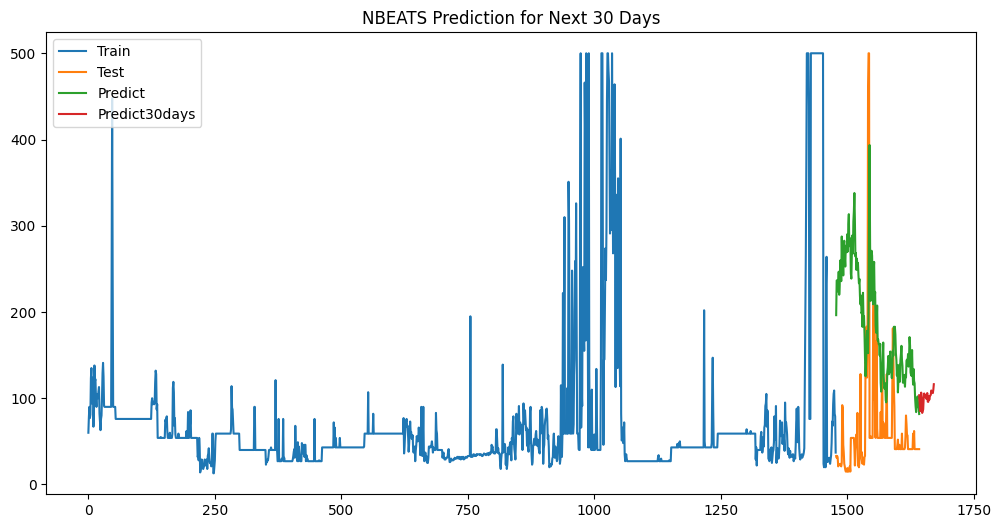

In [137]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()